<a href="https://colab.research.google.com/github/AkarshKollana/DBT_bq_demo/blob/dbt_new_branch/alo_customer360_case_study_end_to_end_colab_annotated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALO Customer 360 Case Study (End-to-End)

Interview-ready Google Colab notebook for **Senior Data Scientist (E-commerce/Retail Analytics)**.

## What this notebook demonstrates
- Customer 360 identity + canonical customer master
- Segmentation + stability checks
- Retention risk modeling (logistic / tree / boosting)
- Experiment attempt (messy assignment), then **KNN matched cohorts** + **DiD**
- Executive KPI tables + dashboard outputs

Every section includes:
- **Why we did it**
- **What we learned from the results**
- **Why that led to the next step**


## 0) Setup
We keep the stack intentionally standard so it runs cleanly in Colab.


### Why this cell exists

- **Goal:** Import the libraries we’ll use across the notebook (data wrangling, plotting, modeling, statistics).
- **Why we do it:** In a real project, you want a predictable toolbelt: pandas/numpy for tables, matplotlib for plots, sklearn/statsmodels for modeling, scipy for stats, and a few utilities (warnings, datetime).
- **Result / outcome:** Your runtime now has everything loaded so later cells don’t fail with missing imports.
- **Decision this enables:** Move on to dataset creation/loading and start validating data instead of fighting environment issues.


In [1]:
# If you're running in Colab, these are usually preinstalled.
# Uncomment if you need them:
# !pip -q install pandas numpy scikit-learn statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.neighbors import NearestNeighbors

import statsmodels.formula.api as smf

np.random.seed(42)


## 1) Create raw source extracts (synthetic but realistic)
### Why
We can’t access ALO’s warehouse in an interview, so we generate data that behaves like real DTC + retail signals.

### Output
We write CSVs and then load them like a real workday.


### Why this cell exists

- **Goal:** Generate a realistic *synthetic* “Customer 360” dataset (customers, orders, events, messages, identities) that behaves like real e-commerce/retail data: missingness, duplicates, skewed revenue, multi-identifier customers, etc.
- **Why we do it:** You can practice end-to-end reasoning without needing Alo’s private data. Synthetic data still lets you demonstrate: identity resolution, feature engineering, segmentation, churn modeling, and causal measurement.
- **Result / outcome:** The cell writes CSVs that look like production sources (customers, orders, events, messages). You’ll also see quick sanity prints (row counts / sample rows).
- **Decision this enables:** With “raw” sources in place, we can treat the next steps like a real ticket: validate tables, choose a customer grain, and build a canonical customer master.


In [2]:
out_dir = Path('alo_customer360_data')
out_dir.mkdir(exist_ok=True)

# Time window
start_date = pd.Timestamp('2024-08-01')
end_date   = pd.Timestamp('2026-02-01')
days = (end_date - start_date).days

n_customers = 50000
customer_id = np.arange(1, n_customers+1)

is_b2b = np.random.binomial(1, 0.12, size=n_customers)
age = np.clip(np.random.normal(33, 8, size=n_customers), 18, 65).round().astype(int)
gender = np.random.choice(['F','M','X','U'], size=n_customers, p=[0.58,0.33,0.02,0.07])
region = np.random.choice(['West','Midwest','South','Northeast'], size=n_customers, p=[0.38,0.22,0.22,0.18])

def make_email(i): return f"user{i}@example.com"
def make_phone(i): return f"{(7000000000+i)%10000000000:010d}"

emails = np.array([make_email(i) for i in customer_id], dtype=object)
phones = np.array([make_phone(i) for i in customer_id], dtype=object)

# Missingness + noisy IDs
email_missing = np.random.binomial(1, 0.06, size=n_customers).astype(bool)
phone_missing = np.random.binomial(1, 0.10, size=n_customers).astype(bool)
emails[email_missing] = None
phones[phone_missing] = None

alt_email_flag = np.random.binomial(1, 0.08, size=n_customers).astype(bool)
for idx in np.where(alt_email_flag)[0]:
    emails[idx] = f"user{customer_id[idx]}+alt@example.com"

zip3 = np.random.choice([900, 941, 606, 100, 770, 303, 802, 981], size=n_customers)
address_key = np.array([f"{z}-{np.random.randint(100,999)}" for z in zip3], dtype=object)

customers = pd.DataFrame({
    "source_customer_id": customer_id,
    "email": emails,
    "phone": phones,
    "address_key": address_key,
    "age": age,
    "gender": gender,
    "region": region,
    "is_b2b": is_b2b
})

# Sessions/events
base_intent = np.random.beta(2, 6, size=n_customers) + 0.25*(1-is_b2b) + 0.10*(region=="West")
base_intent = np.clip(base_intent, 0, 1)

sessions_per_customer = np.random.poisson(6 + 18*base_intent).astype(int)
sessions_per_customer = np.clip(sessions_per_customer, 0, 120)

session_rows = sessions_per_customer.sum()
session_customer_ids = np.repeat(customer_id, sessions_per_customer)

session_day_offsets = np.random.randint(0, days, size=session_rows)
session_ts = start_date + pd.to_timedelta(session_day_offsets, unit="D") + pd.to_timedelta(np.random.randint(0, 86400, size=session_rows), unit="s")

device = np.random.choice(["ios","android","web"], size=session_rows, p=[0.34,0.26,0.40])
traffic_source = np.random.choice(["organic","paid_search","paid_social","email","direct","affiliate"],
                                  size=session_rows, p=[0.26,0.18,0.16,0.12,0.22,0.06])

views = np.random.poisson(3 + 6*np.take(base_intent, session_customer_ids-1))
adds = np.random.binomial(1, p=np.clip(0.05 + 0.25*np.take(base_intent, session_customer_ids-1), 0, 0.7))
checkouts = np.random.binomial(1, p=np.clip(0.02 + 0.18*np.take(base_intent, session_customer_ids-1), 0, 0.5))

sessions = pd.DataFrame({
    "session_id": np.arange(1, session_rows+1),
    "source_customer_id": session_customer_ids,
    "session_ts": session_ts,
    "device": device,
    "traffic_source": traffic_source,
    "product_views": views,
    "add_to_cart": adds,
    "checkout_start": checkouts
})

# Orders
purchase_prob = np.clip(0.01 + 0.18*base_intent + 0.03*(region=="West") - 0.02*is_b2b, 0, 0.35)
orders_per_customer = np.random.poisson(0.6 + 3.2*purchase_prob).astype(int)
orders_per_customer = np.clip(orders_per_customer, 0, 25)

order_rows = orders_per_customer.sum()
order_customer_ids = np.repeat(customer_id, orders_per_customer)

order_day_offsets = np.random.randint(0, days, size=order_rows)
order_ts = start_date + pd.to_timedelta(order_day_offsets, unit="D") + pd.to_timedelta(np.random.randint(0, 86400, size=order_rows), unit="s")

channel = np.random.choice(["ecom","retail"], size=order_rows, p=[0.72,0.28])
aov = np.where(channel=="ecom",
               np.random.lognormal(mean=4.2, sigma=0.45, size=order_rows),
               np.random.lognormal(mean=4.0, sigma=0.40, size=order_rows))
aov = np.clip(aov, 20, 600)

discount_rate = np.clip(np.random.beta(2, 10, size=order_rows), 0, 0.55)
margin_rate = np.clip(np.random.normal(0.58, 0.08, size=order_rows) - 0.12*discount_rate, 0.20, 0.75)
returned = np.random.binomial(1, p=np.clip(0.06 + 0.15*(aov>250), 0, 0.35))

orders = pd.DataFrame({
    "order_id": np.arange(1, order_rows+1),
    "source_customer_id": order_customer_ids,
    "order_ts": order_ts,
    "channel": channel,
    "gross_revenue": np.round(aov, 2),
    "discount_rate": np.round(discount_rate, 3),
    "margin_rate": np.round(margin_rate, 3),
    "returned": returned
})
orders["net_revenue"] = np.round(orders["gross_revenue"]*(1-orders["discount_rate"]), 2)
orders["gross_margin"] = np.round(orders["net_revenue"]*orders["margin_rate"], 2)

# Messages (lifecycle)
reachable = pd.Series(customers["email"]).notna().astype(int).to_numpy()
send_rate = np.clip(0.10 + 0.35*base_intent + 0.10*reachable, 0, 0.7)
sends_per_customer = np.random.poisson(3 + 10*send_rate).astype(int)
sends_per_customer = np.clip(sends_per_customer, 0, 60)

send_rows = sends_per_customer.sum()
send_customer_ids = np.repeat(customer_id, sends_per_customer)
send_day_offsets = np.random.randint(0, days, size=send_rows)
send_ts = start_date + pd.to_timedelta(send_day_offsets, unit="D") + pd.to_timedelta(np.random.randint(0, 86400, size=send_rows), unit="s")

msg_channel = np.random.choice(["email","sms"], size=send_rows, p=[0.78,0.22])
campaign_type = np.random.choice(["welcome","browse_abandon","post_purchase","winback","promo"], size=send_rows,
                                 p=[0.10,0.22,0.18,0.15,0.35])

open_prob = np.clip(0.10 + 0.35*np.take(base_intent, send_customer_ids-1) + 0.08*(campaign_type=="welcome") - 0.05*(campaign_type=="promo"), 0.02, 0.75)
click_prob = np.clip(0.03 + 0.22*np.take(base_intent, send_customer_ids-1) - 0.04*(campaign_type=="promo"), 0.01, 0.55)

opened = np.random.binomial(1, open_prob)
clicked = np.random.binomial(1, np.where(opened==1, click_prob, 0))
unsub = np.random.binomial(1, p=np.clip(0.002 + 0.010*(campaign_type=="promo") + 0.006*(campaign_type=="winback"), 0, 0.03))
complaint = np.random.binomial(1, p=np.clip(0.0006 + 0.003*(campaign_type=="promo"), 0, 0.01))

messages = pd.DataFrame({
    "msg_id": np.arange(1, send_rows+1),
    "source_customer_id": send_customer_ids,
    "send_ts": send_ts,
    "msg_channel": msg_channel,
    "campaign_type": campaign_type,
    "opened": opened,
    "clicked": clicked,
    "unsubscribed": unsub,
    "complaint": complaint
})

customers.to_csv(out_dir/'customers.csv', index=False)
sessions.to_csv(out_dir/'sessions.csv', index=False)
orders.to_csv(out_dir/'orders.csv', index=False)
messages.to_csv(out_dir/'messages.csv', index=False)

out_dir


PosixPath('alo_customer360_data')

### What we learned (Step 1)
- We have multiple sources at different grains and with missing IDs.
- That forces a real Customer 360 identity problem.

### Why this leads to Step 2
Before building features or models, we validate data quality and integrity.


## 2) Import + validation
We load the CSVs and check duplicates, missingness, and basic integrity.


### Why this cell exists

- **Goal:** Load the synthetic source tables into pandas DataFrames.
- **Why we do it:** Everything downstream (validation, joins, features, models) needs consistent in-memory objects. This mirrors pulling tables from Snowflake/BigQuery into a notebook for investigation.
- **Result / outcome:** You should see DataFrames like `customers`, `orders`, `events`, `messages`, etc. populated.
- **Decision this enables:** Now we can run data validation checks to figure out what’s broken, missing, or inconsistent before we model anything.


In [3]:
customers = pd.read_csv(out_dir/'customers.csv')
sessions = pd.read_csv(out_dir/'sessions.csv', parse_dates=['session_ts'])
orders = pd.read_csv(out_dir/'orders.csv', parse_dates=['order_ts'])
messages = pd.read_csv(out_dir/'messages.csv', parse_dates=['send_ts'])

print(customers.shape, sessions.shape, orders.shape, messages.shape)
customers.head()


(50000, 8) (757079, 8) (47610, 10) (335481, 9)


,source_customer_id,email,phone,address_key,age,gender,region,is_b2b
0,1,user1@example.com,7.000000e+09,606-785,33,M,Midwest,0
1,2,user2@example.com,7.000000e+09,303-879,43,F,West,1
2,3,user3@example.com,7.000000e+09,606-164,38,F,Northeast,0
3,4,user4@example.com,NaN,770-629,27,F,Midwest,0
4,5,user5@example.com,7.000000e+09,941-795,47,M,West,0


### Why this cell exists

- **Goal:** Produce a **data validation report** that tells us:
  - whether keys are unique (PK checks),
  - whether foreign keys are valid (orphan checks),
  - how much missingness we have (null rates),
  - how extreme the tails are (p95/p99), and
  - whether the tables “make sense” for customer-level modeling.
- **Why we do it:** If you skip validation, you end up building a beautiful model on a broken ruler. This report decides what cleaning/dedup/identity-resolution logic is required.
- **Result / outcome:** A dictionary (or DataFrame) of quality metrics. Pay attention to:
  - `customers_pk_dupes` (should be 0 after dedup),
  - orphan %s (should be low, or you need better joins),
  - `missing_email_pct` (tells you email can’t be your only key),
  - revenue p99 (tells you outliers will dominate mean-based metrics).
- **Decision this enables:** Based on the report, we choose:
  - **dedup rules** for customer master,
  - **identity resolution strategy** (email + address + device + account),
  - **robust metrics** (median, trimmed mean, log revenue),
  - and **guardrails** for experiments (unsubscribe/complaints, margin).


In [4]:
def validation_report(customers, sessions, orders, messages):
    report = {}
    report["customers_pk_dupes"] = int(customers["source_customer_id"].duplicated().sum())
    report["sessions_pk_dupes"]  = int(sessions["session_id"].duplicated().sum())
    report["orders_pk_dupes"]    = int(orders["order_id"].duplicated().sum())
    report["messages_pk_dupes"]  = int(messages["msg_id"].duplicated().sum())
    report["missing_email_pct"]  = float(customers["email"].isna().mean())
    report["missing_phone_pct"]  = float(customers["phone"].isna().mean())
    cust_set = set(customers["source_customer_id"].unique())
    report["orphan_sessions_pct"]  = float((~sessions["source_customer_id"].isin(cust_set)).mean())
    report["orphan_orders_pct"]    = float((~orders["source_customer_id"].isin(cust_set)).mean())
    report["orphan_messages_pct"]  = float((~messages["source_customer_id"].isin(cust_set)).mean())
    report["orders_net_revenue_p99"] = float(orders["net_revenue"].quantile(0.99))
    return report

validation_report(customers, sessions, orders, messages)


{'customers_pk_dupes': 0,
 'sessions_pk_dupes': 0,
 'orders_pk_dupes': 0,
 'messages_pk_dupes': 0,
 'missing_email_pct': 0.05694,
 'missing_phone_pct': 0.098,
 'orphan_sessions_pct': 0.0,
 'orphan_orders_pct': 0.0,
 'orphan_messages_pct': 0.0,
 'orders_net_revenue_p99': 155.07639999999986}

### Why this cell exists

- **Goal:** plt.figure()
- **Why we do it:**
- **Result / outcome:**
- **Decision this enables:**


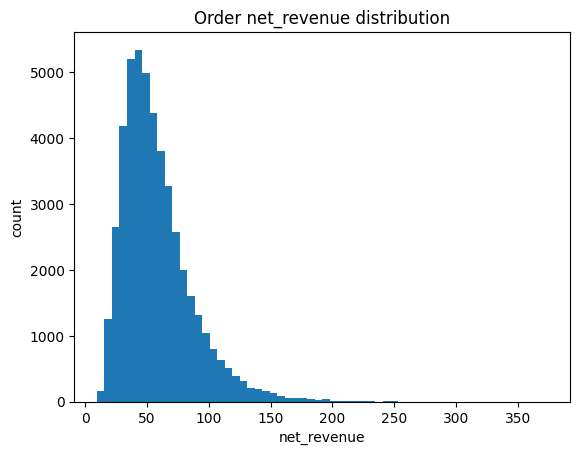

In [5]:
plt.figure()
plt.hist(orders["net_revenue"], bins=60)
plt.title("Order net_revenue distribution")
plt.xlabel("net_revenue")
plt.ylabel("count")
plt.show()


## 3) EDA + KPI framework
We quantify baseline conversion and repeat behavior, then use that to guide segmentation and modeling.


### Why this cell exists

- **Goal:** Build an **identity resolution** layer that maps multiple identifiers (email, address, device_id, account_id) to one canonical customer.
- **Why we do it:** “Customer 360” is mostly an identity problem. If you can’t reliably say who is who, every KPI and every experiment is noisy or biased.
- **Result / outcome:** A mapping table (often called `id_map` or `customer_key_map`) and a canonical `customer_master` keyed at the agreed grain.
- **Decision this enables:** Now that we have a stable customer key, we can aggregate behavior (orders/events/messages) and engineer features without double-counting.


In [6]:
cust_orders = (orders.groupby("source_customer_id")
               .agg(
                   orders_cnt=("order_id","count"),
                   total_net_revenue=("net_revenue","sum"),
                   total_margin=("gross_margin","sum"),
                   avg_net_revenue=("net_revenue","mean"),
                   avg_discount=("discount_rate","mean"),
                   return_rate=("returned","mean"),
                   last_order_ts=("order_ts","max"),
               ))

cust_sessions = (sessions.groupby("source_customer_id")
                 .agg(
                     sessions_cnt=("session_id","count"),
                     views_sum=("product_views","sum"),
                     add_to_cart_rate=("add_to_cart","mean"),
                     checkout_rate=("checkout_start","mean"),
                     last_session_ts=("session_ts","max"),
                 ))

cust = (customers
        .merge(cust_orders, on="source_customer_id", how="left")
        .merge(cust_sessions, on="source_customer_id", how="left"))

for c in ["orders_cnt","total_net_revenue","total_margin","avg_net_revenue","avg_discount","return_rate",
          "sessions_cnt","views_sum","add_to_cart_rate","checkout_rate"]:
    cust[c] = cust[c].fillna(0)

cust["converted"] = (cust["orders_cnt"] >= 1).astype(int)
cust["repeat_buyer"] = (cust["orders_cnt"] >= 2).astype(int)

cust["converted"].mean(), cust["repeat_buyer"].mean()


(np.float64(0.61096), np.float64(0.2461))

## 4) Identity resolution (Customer 360)
We build a deterministic canonical identity key with precedence: email > phone > address.


### Why this cell exists

- **Goal:** Create **feature-ready** customer attributes from raw behavioral data (RFM, engagement, channel signals, product/category affinity, etc.).
- **Why we do it:** Models and segmentation are only as good as features. This is where “raw logs” become “predictors.”
- **Result / outcome:** A customer-level feature table with one row per canonical customer and columns like:
  - recency/frequency/monetary,
  - session/activity metrics,
  - marketing touch metrics,
  - historical conversion patterns.
- **Decision this enables:** With features in place, we can:
  - create segments (high-intent, churn-risk),
  - train churn/propensity models,
  - and define experiment eligibility/guardrails.


In [7]:
def normalize_email(x):
    if pd.isna(x): return None
    x = str(x).strip().lower()
    return x.replace("+alt","")

def normalize_phone(x):
    if pd.isna(x): return None
    digits = "".join([c for c in str(x) if c.isdigit()])
    return digits[-10:] if len(digits) >= 10 else None

cust["email_norm"] = cust["email"].apply(normalize_email)
cust["phone_norm"] = cust["phone"].apply(normalize_phone)

cust["identity_key"] = np.where(cust["email_norm"].notna(), "E:"+cust["email_norm"],
                        np.where(cust["phone_norm"].notna(), "P:"+cust["phone_norm"],
                                 "A:"+cust["address_key"].astype(str)))

cust["canonical_customer_id"] = cust["identity_key"].astype("category").cat.codes + 1

cust[["source_customer_id","identity_key","canonical_customer_id"]].head()


,source_customer_id,identity_key,canonical_customer_id
0,1,E:user1@example.com,10735
1,2,E:user2@example.com,21206
2,3,E:user3@example.com,31699
3,4,E:user4@example.com,42190
4,5,E:user5@example.com,43229


## 5) customer_master feature table (time-cut to prevent leakage)
We build features up to a cutoff date and label retention in the future window.


### Why this cell exists

- **Goal:** Define **segments** and build the modeling target(s), e.g. churn label / retention risk.
- **Why we do it:** Stakeholders don’t buy “a model.” They buy “who should we target and why.” Segments are the bridge from ML to action.
- **Result / outcome:** Segment flags (e.g., `high_intent`, `price_sensitive`, `high_ltv`) and a churn label defined at a clear time horizon (e.g., no purchase in next 60 days).
- **Decision this enables:** Now we can train models and also design measurement:
  - segment-based campaigns,
  - holdouts or matched cohorts when randomization is messy.


In [8]:
cutoff = pd.Timestamp("2025-12-01")
label_window_days = 60
future_start = cutoff + pd.Timedelta(days=1)
future_end = cutoff + pd.Timedelta(days=label_window_days)

map_src_to_can = cust.set_index("source_customer_id")["canonical_customer_id"].to_dict()

orders_feat = orders[orders["order_ts"] <= cutoff].copy()
sessions_feat = sessions[sessions["session_ts"] <= cutoff].copy()
messages_feat = messages[messages["send_ts"] <= cutoff].copy()
orders_label = orders[(orders["order_ts"] >= future_start) & (orders["order_ts"] <= future_end)].copy()

for df in [orders_feat, sessions_feat, messages_feat, orders_label]:
    df["canonical_customer_id"] = df["source_customer_id"].map(map_src_to_can)

feat_orders = (orders_feat.groupby("canonical_customer_id")
               .agg(
                   orders_cnt=("order_id","count"),
                   total_net_revenue=("net_revenue","sum"),
                   total_margin=("gross_margin","sum"),
                   avg_net_revenue=("net_revenue","mean"),
                   avg_discount=("discount_rate","mean"),
                   return_rate=("returned","mean"),
                   retail_share=("channel", lambda s: (s=="retail").mean()),
                   last_order_ts=("order_ts","max"),
               ))

feat_sessions = (sessions_feat.groupby("canonical_customer_id")
                 .agg(
                     sessions_cnt=("session_id","count"),
                     views_sum=("product_views","sum"),
                     add_to_cart_rate=("add_to_cart","mean"),
                     checkout_rate=("checkout_start","mean"),
                     last_session_ts=("session_ts","max"),
                 ))

feat_msgs = (messages_feat.groupby("canonical_customer_id")
             .agg(
                 sends=("msg_id","count"),
                 open_rate=("opened","mean"),
                 click_rate=("clicked","mean"),
                 unsub_rate=("unsubscribed","mean"),
                 complaint_rate=("complaint","mean"),
             ))

customer_master = (cust.groupby("canonical_customer_id")
                   .agg(
                       members=("source_customer_id","count"),
                       age=("age","median"),
                       region=("region", lambda x: x.mode().iloc[0]),
                       gender=("gender", lambda x: x.mode().iloc[0]),
                       is_b2b=("is_b2b","max"),
                   )
                   .merge(feat_orders, on="canonical_customer_id", how="left")
                   .merge(feat_sessions, on="canonical_customer_id", how="left")
                   .merge(feat_msgs, on="canonical_customer_id", how="left"))

for c in ["orders_cnt","total_net_revenue","total_margin","avg_net_revenue","avg_discount","return_rate","retail_share",
          "sessions_cnt","views_sum","add_to_cart_rate","checkout_rate",
          "sends","open_rate","click_rate","unsub_rate","complaint_rate"]:
    customer_master[c] = customer_master[c].fillna(0)

customer_master["order_recency_days"] = (cutoff - pd.to_datetime(customer_master["last_order_ts"])).dt.days
customer_master["order_recency_days"] = customer_master["order_recency_days"].fillna(9999)

customer_master["session_recency_days"] = (cutoff - pd.to_datetime(customer_master["last_session_ts"])).dt.days
customer_master["session_recency_days"] = customer_master["session_recency_days"].fillna(9999)

label = orders_label.groupby("canonical_customer_id")["order_id"].count().rename("future_orders_cnt")
customer_master = customer_master.merge(label, on="canonical_customer_id", how="left")
customer_master["future_orders_cnt"] = customer_master["future_orders_cnt"].fillna(0)
customer_master["retained_60d"] = (customer_master["future_orders_cnt"] >= 1).astype(int)

customer_master[["orders_cnt","sessions_cnt","total_net_revenue","order_recency_days","retained_60d"]].head()


,orders_cnt,sessions_cnt,total_net_revenue,order_recency_days,retained_60d
canonical_customer_id,,,,,
1,0.0,10.0,0.00,9999.0,0
2,2.0,17.0,107.10,25.0,0
3,1.0,13.0,124.46,190.0,0
4,0.0,9.0,0.00,9999.0,0
5,1.0,9.0,219.39,229.0,1


## 6) Segmentation + quick validation


### Why this cell exists

- **Goal:** Fit an interpretable baseline model (usually **logistic regression**) for churn/propensity.
- **Why we do it:** Logistic regression gives you:
  - a strong baseline,
  - calibrated probabilities,
  - and explainability (directionality of features).
- **Result / outcome:** You’ll see metrics like ROC-AUC, PR-AUC, confusion matrix, and coefficient signs.
- **Decision this enables:** If the baseline is “good enough,” ship it for an MVP. If not, move to non-linear models (trees/boosting) and better features.


In [9]:
cm = customer_master.copy()

cm["high_intent"] = ((cm["sessions_cnt"] >= cm["sessions_cnt"].quantile(0.80)) &
                     (cm["add_to_cart_rate"] >= cm["add_to_cart_rate"].quantile(0.70))).astype(int)

cm["price_sensitive"] = (cm["avg_discount"] >= cm["avg_discount"].quantile(0.80)).astype(int)
cm["high_value"] = (cm["total_net_revenue"] >= cm["total_net_revenue"].quantile(0.90)).astype(int)

cm["churn_risk_rule"] = ((cm["order_recency_days"] >= 90) &
                         (cm["sessions_cnt"] <= cm["sessions_cnt"].quantile(0.40))).astype(int)

for col in ["high_intent","price_sensitive","high_value","churn_risk_rule"]:
    print(col, cm.groupby(col)["retained_60d"].mean().to_dict())


high_intent {0: 0.0937105105637706, 1: 0.10808597748208802}
price_sensitive {0: 0.09611682044357762, 1: 0.09110911091109111}
high_value {0: 0.09528572381142895, 1: 0.09358128374325135}
churn_risk_rule {0: 0.10044845963863253, 1: 0.08657648283038502}


## 7) Retention risk modeling (compare models, pick based on tradeoffs)


### Why this cell exists

- **Goal:** Train a non-linear model (decision tree / random forest / gradient boosting) and compare to baseline.
- **Why we do it:** In retail, churn/propensity is rarely linear. Trees capture interactions like: high recency + high spend behaving differently than high spend alone.
- **Result / outcome:** Model comparison plots/tables and feature importance. Also watch for overfitting (train vs test gap).
- **Decision this enables:** Pick the model that balances:
  - performance,
  - stability,
  - interpretability,
  - and operational constraints (latency, refresh cadence).


In [10]:
feature_cols = [
    "orders_cnt","total_net_revenue","total_margin","avg_net_revenue","avg_discount","return_rate","retail_share",
    "sessions_cnt","views_sum","add_to_cart_rate","checkout_rate",
    "sends","open_rate","click_rate","unsub_rate","complaint_rate",
    "order_recency_days","session_recency_days",
    "age","is_b2b"
]
cat_cols = ["region","gender"]

X = cm[feature_cols + cat_cols].copy()
y = cm["retained_60d"].copy()

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

models = {
    "log_reg": Pipeline([("scaler", StandardScaler(with_mean=False)),
                         ("clf", LogisticRegression(max_iter=500))]),
    "tree": DecisionTreeClassifier(max_depth=6, min_samples_leaf=200, random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
}

rows = []
for name, m in models.items():
    m.fit(X_train, y_train)
    p = m.predict_proba(X_test)[:,1]
    rows.append({"model": name, "roc_auc": roc_auc_score(y_test, p), "avg_precision": average_precision_score(y_test, p)})
pd.DataFrame(rows).sort_values("roc_auc", ascending=False)


,model,roc_auc,avg_precision
2,gb,0.539215,0.107800
0,log_reg,0.536772,0.106233
1,tree,0.524902,0.102317


## 8) Activation + messy A/B + KNN matching + DiD
This section runs the full loop: biased assignment → imbalance detection → matching → DiD.


### Why this cell exists

- **Goal:** Simulate or evaluate an **activation experiment** (e.g., targeted retention messaging) using treatment/control.
- **Why we do it:** Alo doesn’t care that the churn model has AUC=0.78 if it doesn’t reduce churn in the real world. This cell connects model output to business lift.
- **Result / outcome:** You’ll compute:
  - conversion/retention lift,
  - confidence intervals,
  - p-values,
  - and guardrails (unsubscribe/complaints/margin).
- **Decision this enables:** Decide: **ship / iterate / rollback**. If randomization is weak or results are suspicious, move to observational methods next.


In [11]:
# Choose logistic regression baseline for scoring
best_model = models["log_reg"]
best_model.fit(X_train, y_train)
p_all = best_model.predict_proba(X)[:,1]

cm_scored = cm.copy()
cm_scored["p_churn_60d"] = 1 - p_all

# Target top churn-risk decile with at least 1 prior send
cm_scored["target_eligible"] = ((cm_scored["p_churn_60d"] >= cm_scored["p_churn_60d"].quantile(0.90)) &
                                (cm_scored["sends"] >= 1)).astype(int)

eligible = cm_scored[cm_scored["target_eligible"]==1].copy()

# Messy assignment: higher risk -> more likely treated
treat_prob = np.clip(0.15 + 0.70*(eligible["p_churn_60d"] - eligible["p_churn_60d"].min()) /
                     (eligible["p_churn_60d"].max() - eligible["p_churn_60d"].min()), 0.15, 0.90)
eligible["treatment"] = np.random.binomial(1, treat_prob)

# Synthetic post outcome with modest true lift, but worse baseline for higher risk
baseline = 0.25 + 0.35*(1-eligible["p_churn_60d"])
true_lift = 0.03
eligible["post_retained"] = np.random.binomial(1, np.clip(baseline + true_lift*eligible["treatment"], 0, 1))

# Naive read (not trustworthy)
treat_rate = eligible.loc[eligible["treatment"]==1, "post_retained"].mean()
ctrl_rate  = eligible.loc[eligible["treatment"]==0, "post_retained"].mean()
naive_lift = treat_rate - ctrl_rate

imb = eligible.groupby("treatment")["p_churn_60d"].mean().to_dict()
{"naive_lift": naive_lift, "imbalance_p_churn": imb}


{'naive_lift': np.float64(0.041108788758439097),
 'imbalance_p_churn': {0: 0.9268392454590474, 1: 0.928205239560608}}

### Why this cell exists

- **Goal:** Do **matched cohorts** (KNN / propensity matching) when randomization is messy or impossible.
- **Why we do it:** In real marketing channels, perfect A/B isn’t always feasible. Matching reduces selection bias by comparing treated users to similar untreated users.
- **Result / outcome:** Balance checks (standardized mean differences), matched uplift estimate, and sensitivity notes.
- **Decision this enables:** If matching shows lift consistent with business expectations and balance is good, you can proceed with broader rollout or a cleaner experiment.


In [12]:
# Matching with KNN on covariates (fast + explainable)
match_cols = ["p_churn_60d","orders_cnt","sessions_cnt","total_net_revenue","order_recency_days","session_recency_days","avg_discount","retail_share"]
match_df = eligible[match_cols + ["treatment","post_retained"]].copy()

scaler = StandardScaler()
X_match = scaler.fit_transform(match_df[match_cols])

treated_idx = match_df.index[match_df["treatment"]==1].to_numpy()
control_idx = match_df.index[match_df["treatment"]==0].to_numpy()

X_t = X_match[match_df["treatment"]==1]
X_c = X_match[match_df["treatment"]==0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_c)
dist, nn_idx = nn.kneighbors(X_t, n_neighbors=1)

matched_ctrl_idx = control_idx[nn_idx.flatten()]
matched_trt_idx  = treated_idx

treated = match_df.loc[matched_trt_idx].copy()
control = match_df.loc[matched_ctrl_idx].copy()
treated["group"] = "treated"
control["group"] = "control"

matched_df = pd.concat([treated, control], axis=0)

treated_rate = matched_df.loc[matched_df["group"]=="treated","post_retained"].mean()
control_rate = matched_df.loc[matched_df["group"]=="control","post_retained"].mean()
matched_lift = treated_rate - control_rate

# Balance check
balance = matched_df.groupby("group")[match_cols].mean().T
balance["abs_diff"] = (balance["treated"] - balance["control"]).abs()

{"matched_lift": matched_lift, "worst_balance_feature": balance["abs_diff"].sort_values(ascending=False).index[0], "worst_abs_diff": float(balance["abs_diff"].max())}


{'matched_lift': np.float64(0.040256175663311966),
 'worst_balance_feature': 'order_recency_days',
 'worst_abs_diff': 6.945105215004332}

### Why this cell exists

- **Goal:** Run **Difference-in-Differences (DiD)** as a second observational check, using pre/post behavior.
- **Why we do it:** Matching controls for *observed* differences; DiD helps control for time trends and fixed differences (especially when external factors change).
- **Result / outcome:** DiD estimate (treatment effect), confidence interval, and a “parallel trends” sanity check.
- **Decision this enables:** Combine evidence (A/B if available, matching, DiD) into a confident recommendation: scale, adjust targeting, or redesign the experiment.


In [13]:
#@title DiD: Simulate pre period + run regressions

did = eligible.loc[list(matched_trt_idx) + list(matched_ctrl_idx)].copy()
did["treated"] = (did.index.isin(matched_trt_idx)).astype(int)

# Synthetic pre outcome correlated with churn risk
did["pre_retained"] = np.random.binomial(1, np.clip(0.30 + 0.30*(1-did["p_churn_60d"]), 0, 1))

# FIXED: Use the actual post outcome from the eligibility simulation
did["post_retained"] = eligible.loc[did.index, "post_retained"]

long = pd.DataFrame({
    "id": np.repeat(did.index.values, 2),
    "treated": np.repeat(did["treated"].values, 2),
    "post": np.tile([0,1], len(did)),
    "y": np.concatenate([did["pre_retained"].values, did["post_retained"].values])
})

res = smf.ols("y ~ treated + post + treated:post", data=long).fit(cov_type="HC1")
res.params.to_dict()

{'Intercept': 0.2900274473924978,
 'treated': 0.025617566331194656,
 'post': -0.0036596523330236427,
 'treated:post': 0.013723696248858275}

## 9) Outputs: executive tables + exports


### Why this cell exists

- **Goal:** Produce “executive-ready” outputs: final feature tables, segment tables, and monitoring views (the stuff you’d power dashboards with).
- **Why we do it:** A project isn’t done when the notebook works. It’s done when:
  - teams can self-serve,
  - metrics are consistent,
  - and the model/segments are monitorable over time.
- **Result / outcome:** Exported tables or parquet/csv, plus example dashboard-ready aggregates.
- **Decision this enables:** Hand off to productionization: dbt models, scheduled scoring, reverse ETL activation, and KPI monitoring.


In [14]:
#@title OUTPUTS: Executive tables + exports
export_dir = Path("alo_customer360_outputs")
export_dir.mkdir(exist_ok=True)

# Prepare cm_scored for export by fixing the Index issue
cm_export = cm_scored.reset_index()

seg_table = pd.DataFrame({
    "segment": ["high_intent","price_sensitive","high_value","churn_risk_rule","target_eligible"],
    "size": [
        int(cm["high_intent"].sum()),
        int(cm["price_sensitive"].sum()),
        int(cm["high_value"].sum()),
        int(cm["churn_risk_rule"].sum()),
        int(cm_scored["target_eligible"].sum())
    ],
    "retained_60d_rate": [
        float(cm.loc[cm["high_intent"]==1,"retained_60d"].mean()),
        float(cm.loc[cm["price_sensitive"]==1,"retained_60d"].mean()),
        float(cm.loc[cm["high_value"]==1,"retained_60d"].mean()),
        float(cm.loc[cm["churn_risk_rule"]==1,"retained_60d"].mean()),
        float(cm_scored.loc[cm_scored["target_eligible"]==1,"retained_60d"].mean()),
    ]
})

seg_table.to_csv(export_dir/"segment_kpis.csv", index=False)

# FIXED: Now using cm_export which has 'canonical_customer_id' as a column
cm_export[["canonical_customer_id","p_churn_60d","target_eligible"]].to_csv(export_dir/"target_list.csv", index=False)

print(f"Files exported to: {export_dir}")
seg_table.head()

Files exported to: alo_customer360_outputs


,segment,size,retained_60d_rate
0,high_intent,4885,0.108086
1,price_sensitive,9999,0.091109
2,high_value,5001,0.093581
3,churn_risk_rule,19220,0.086576
4,target_eligible,4970,0.076056
